# Libraries

In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

## Reading input file

In [240]:
data = pd.read_excel('C:\course work\career\TTI\ModelingDataSet.xlsx')

## Explore data

In [241]:
data.head()

,Transaction_ID,Unit_cost,Quantity,Extended_cost,Revenue,Margin%
0,1,0.261167,1200,313.40,468.00,0.330341
1,2,1.073075,400,429.23,572.00,0.249597
2,3,0.109778,2880,316.16,662.88,0.523050
3,4,0.007200,24000,172.80,288.00,0.400000
4,5,0.012630,10000,126.30,320.00,0.605312


In [242]:
data.describe()

,Transaction_ID,Unit_cost,Quantity,Extended_cost,Revenue,Margin%
count,28103.000000,28103.000000,28103.000000,28103.000000,28103.000000,28103.000000
mean,14052.000000,0.210462,5556.689820,276.245760,381.811127,0.411105
std,8112.781644,0.473328,16631.417435,622.663652,790.691345,0.217018
min,1.000000,0.000008,5.000000,0.020000,4.890000,0.091326
25%,7026.500000,0.025100,200.000000,22.500000,57.750000,0.178685
50%,14052.000000,0.109778,1150.000000,86.400000,150.000000,0.443076
75%,21077.500000,0.249111,5000.000000,310.650000,427.200000,0.610069
max,28103.000000,45.849321,600000.000000,21634.120000,28938.000000,0.999927


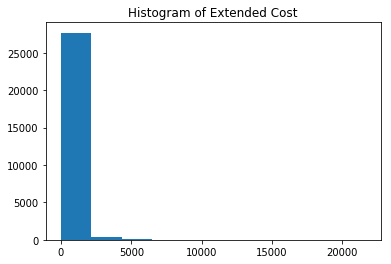

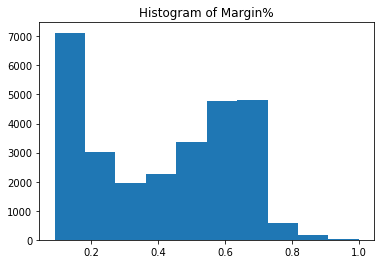

In [243]:
data.rename(columns={data.columns[3]:'Extended_cost','Margin%':'Margin'},inplace=True)
plt.hist(data.Extended_cost)
plt.title('Histogram of Extended Cost')
plt.show()
plt.hist(data.Margin)
plt.title('Histogram of Margin%')
plt.show()

#### The Histogram of Extended cost looks like a logNormal Distribution.

#### Plot log(Extended cost) 

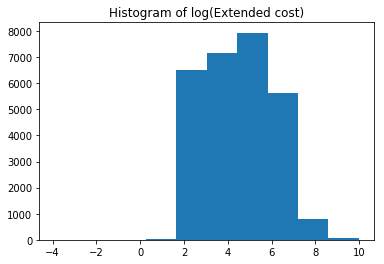

In [244]:
#from ggplot import *
data['log_Extended_cost']=np.log(data.Extended_cost)
plt.hist(data.log_Extended_cost)
plt.title('Histogram of log(Extended cost)')
plt.show()
#ggplot(np.log(data.Extended_cost))

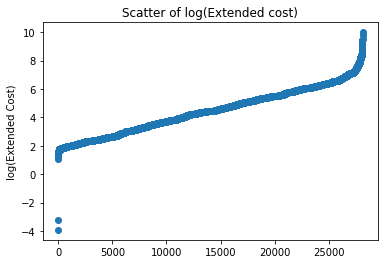

In [245]:
data=data.sort_values(by='Extended_cost',ascending=True)
data=data.reset_index(drop=True)

plt.scatter(range(len(data)),data.log_Extended_cost)
plt.ylabel('log(Extended Cost)')
plt.title('Scatter of log(Extended cost)')
plt.show()

The above graphs shows two outlier (only data points in the negative y axis).These are removed from the analysis from here on

In [246]:
data=data.drop([0,1],axis=0)

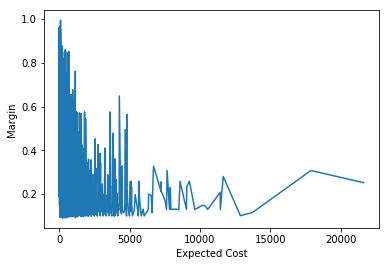

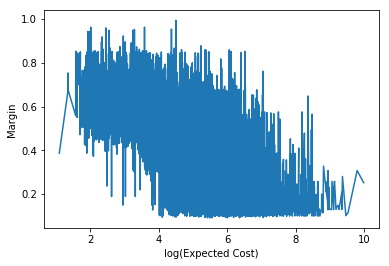

In [247]:
plt.plot(data.Extended_cost,data.Margin)
plt.ylabel('Margin')
plt.xlabel('Expected Cost')
plt.show()
plt.plot(data.log_Extended_cost,data.Margin)
plt.ylabel('Margin')
plt.xlabel('log(Expected Cost)')
plt.show()

An inverse quadratic like relation can be observed between Margin and log(Expected cost)

## Clustering using GaussianMixture algorithm

In [248]:
from sklearn.mixture import GaussianMixture as gmm
%matplotlib inline

features = ['log_Extended_cost','Margin']
ml_data = data[features]

In [249]:
# Function to cluster input data
#      Parameters: clusterk - number of clusters 

def GaussianMixture_cluster(clusterk):
    
    # Using GaussianMixture cluster algorithm
    clusterer = bgmm(n_components=clusterk,covariance_type='spherical', random_state=0,max_iter=200)
    clusterer.fit(ml_data)
    data['nb_b'] = clusterer.predict(ml_data)
    
    # calculate 'mean' and 'coefficient of variance' = std/mean
    
    tmean=0
    tvar=0
    for bin_ in range(0,clusterk):
        mean = (data[data['nb_b'] == bin_]['Margin'].mean()-data.Margin.mean())**2
        std = data[data['nb_b'] == bin_]['log_Extended_cost'].std()
        tmean+=mean
        tvar+=std

    #return the mean and variance
    return tmean,tvar

In [250]:
%%time
# call the function for cluster size between 3 to 11
mean=[]
var=[]
kmax=11
for k in range(3,kmax):
    l=list(GaussianMixture_cluster(k))
    mean.append(l[0])
    var.append(l[1])


Wall time: 20.8 s


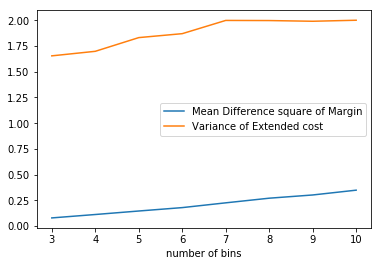

In [251]:
nbins=list(range(3,kmax))
plt.plot(nbins,mean,label='Mean Difference square of Margin')
plt.plot(nbins,var,label='Variance of Extended cost')
plt.xlabel('number of bins')
plt.legend()
plt.show()

The Mean Difference of Margin% and Variance of log(Extended cost), both increase with the number of bins although on different scales. A trade off value between the two can be used to determine Number of bins used (nb_b).

# Plot of clusters 

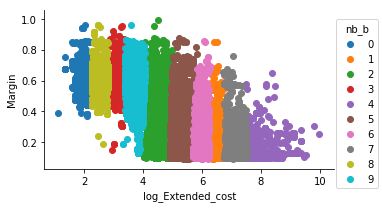

In [252]:
import seaborn
fg = seaborn.FacetGrid(data=data, hue='nb_b', aspect=1.61)
fg.map(plt.scatter, 'log_Extended_cost', 'Margin').add_legend()
plt.show()

## Classification Model

In [253]:
# K nearest neighbors classification

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(data[['log_Extended_cost']], data.nb_b)
preds=neigh.predict(data[['log_Extended_cost']])

In [254]:
import sklearn as sk
sk.metrics.confusion_matrix(data.nb_b,preds)

array([[2371,    0,    0,    0,    0,    0,    0,    0,    1,    0],
       [   0, 2095,    0,    0,    0,    0,    6,    2,    0,    0],
       [   0,    0, 4980,    0,    0,   14,    0,    0,    0,    8],
       [   0,    0,    0, 2589,    0,    0,    0,    0,    3,    4],
       [   0,    0,    0,    0,  503,    0,    0,    1,    0,    0],
       [   0,    0,   12,    0,    0, 4442,   19,    0,    0,    0],
       [   0,    1,    0,    0,    0,    3, 3088,    0,    0,    0],
       [   0,    6,    0,    0,    0,    0,    0, 1356,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 3284,    0],
       [   0,    0,   30,    3,    0,    0,    0,    0,    0, 3280]], dtype=int64)

## Descriptive Measures of Classification Model

In [255]:
for k in range(3,11):
    l=list(GaussianMixture_cluster(k))
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(data[['log_Extended_cost']], data.nb_b)
    preds=neigh.predict(data[['log_Extended_cost']])
    
    print("\n------------------------------------------------------------------------------------------")
    print("Cluster size: ",k)
    print("------------------------------------------------------------------------------------------")
    

    for bin_ in range(0,k):
        mean = data[preds == bin_]['Margin'].mean()
        var=data[preds == bin_]['Margin'].var()
        
        print("  Bin: ",bin_, "Mean Margin: ",mean,", Coefficient of Variation: ",var)
    


------------------------------------------------------------------------------------------
Cluster size:  3
------------------------------------------------------------------------------------------
  Bin:  0 Mean Margin:  0.6201594218260966 , Coefficient of Variation:  0.00667751133215978
  Bin:  1 Mean Margin:  0.23044703777835582 , Coefficient of Variation:  0.019807832907296548
  Bin:  2 Mean Margin:  0.47054067126262 , Coefficient of Variation:  0.03417947321158996

------------------------------------------------------------------------------------------
Cluster size:  4
------------------------------------------------------------------------------------------
  Bin:  0 Mean Margin:  0.6235989467515053 , Coefficient of Variation:  0.006509224961664553
  Bin:  1 Mean Margin:  0.2147977101614036 , Coefficient of Variation:  0.015491826619949236
  Bin:  2 Mean Margin:  0.35522062512846875 , Coefficient of Variation:  0.038328240313942726
  Bin:  3 Mean Margin:  0.5719002103839925 ,

# Other Correlations in Data

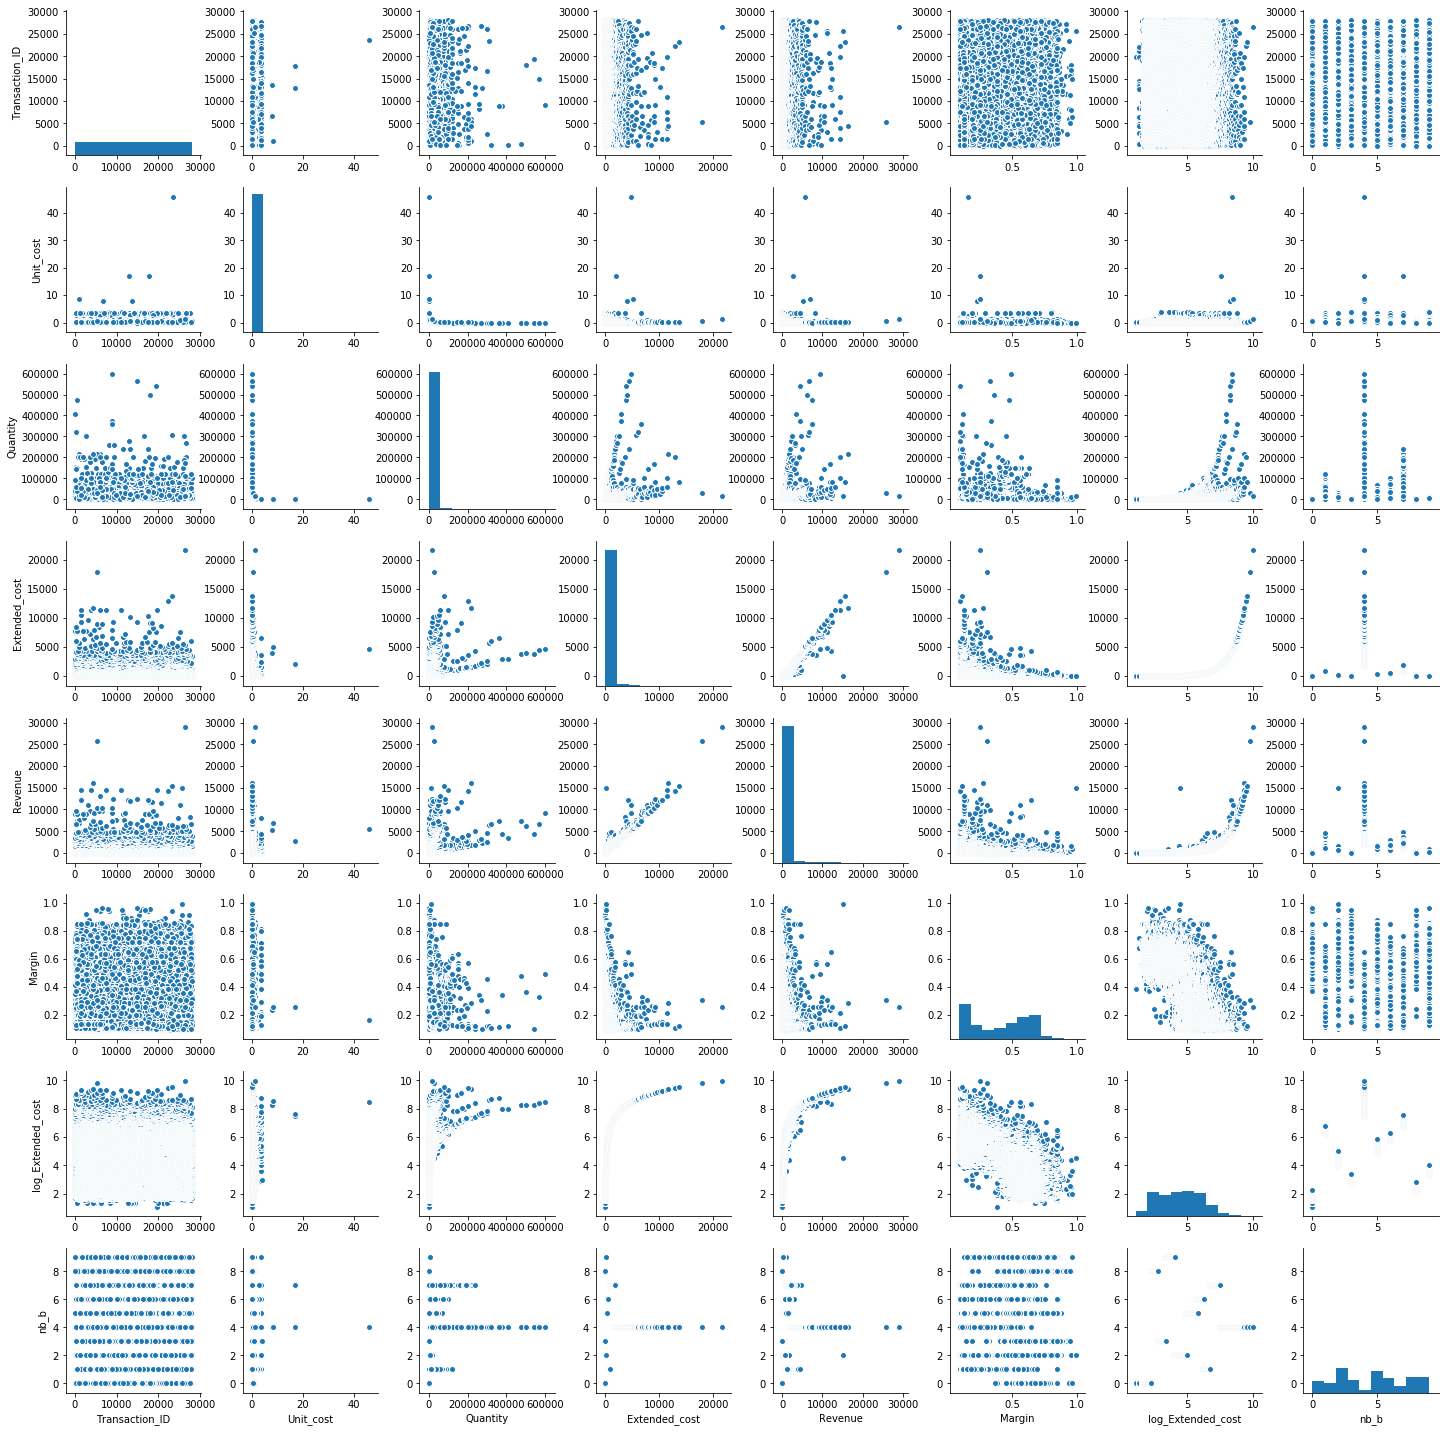

In [256]:
import seaborn as sns
sns.pairplot(data)
plt.show()

Other major correlations of Margin% apparent from the pair plot are with Revenue and Quantity. But these also show high correlation with the Extended_cost column and might not be very useful, but worth a try.